<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Introduction to Data Analytics and Geostatistics and Spatial Data Analytics Courses


## GeostatsPy: Variogram Models Simulation Demonstration 


### Michael Pyrcz, Associate Professor, University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

### Variogram Models

Visualizations with the functions for the common positive definite variogram models.

#### Spatial Continuity 

**Spatial Continuity** is the correlation between values over distance.

* No spatial continuity – no correlation between values over distance, random values at each location in space regardless of separation distance.

* Homogenous phenomenon have perfect spatial continuity, since all values as the same (or very similar) they are correlated. 

We need a statistic to quantify spatial continuity! A convenient method is the Semivariogram.

#### The Semivariogram

Function of difference over distance.

* The expected (average) squared difference between values separated by a lag distance vector (distance and direction), $h$:

\begin{equation}
\gamma(\bf{h}) = \frac{1}{2 N(\bf{h})} \sum^{N(\bf{h})}_{\alpha=1} (z(\bf{u}_\alpha) - z(\bf{u}_\alpha + \bf{h}))^2  
\end{equation}

where $z(\bf{u}_\alpha)$ and $z(\bf{u}_\alpha + \bf{h})$ are the spatial sample values at tail and head locations of the lag vector respectively.

* Calculated over a suite of lag distances to obtain a continuous function.

* the $\frac{1}{2}$ term converts a variogram into a semivariogram, but in practice the term variogram is used instead of semivariogram.
* We prefer the semivariogram because it relates directly to the covariance function, $C_x(\bf{h})$ and univariate variance, $\sigma^2_x$:

\begin{equation}
C_x(\bf{h}) = \sigma^2_x - \gamma(\bf{h})
\end{equation}

Note the correlogram is related to the covariance function as:

\begin{equation}
\rho_x(\bf{h}) = \frac{C_x(\bf{h})}{\sigma^2_x}
\end{equation}

The correlogram provides of function of the $\bf{h}-\bf{h}$ scatter plot correlation vs. lag offset $\bf{h}$.  

\begin{equation}
-1.0 \le \rho_x(\bf{h}) \le 1.0
\end{equation}

#### Variogram Observations

The following are common observations for variograms that should assist with their practical use.

##### Observation \#1 - As distance increases, variability increase (in general).

This is common since in general, over greater distance offsets, there is often more difference between the head and tail samples.

In some cases, such as with spatial cyclicity of the hole effect variogram model the variogram may have negative slope over somelag distance intervals

Negative slopes at lag distances greater than half the data extent are often caused by too few pairs for a reliable variogram calculation

##### Observation \#2 - Calculated with over all possible pairs separated by lag vector, $\bf{𝐡}$.

We scan through the entire data set, searching for all possible pair combinations with all other data.  We then calculate the variogram as one half the expectation of squared difference between all pairs.

More pairs results in a more reliable measure.

##### Observation \#3 - Need to plot the sill to know the degree of correlation.

**Sill** is the variance, $\sigma^2_x$

Given stationarity of the variance, $\sigma^2_x$, and variogram $\gamma(\bf{h})$:

we can define the covariance function:

\begin{equation}
C_x(\bf{h}) = \sigma^2_x - \gamma(\bf{h})
\end{equation}

The covariance measure is a measure of similarity over distance (the mirror image of the variogram as shown by the equation above).

Given a standardized distribution $\sigma^2_x = 1.0$, the covariance, $C_x(\bf{h})$, is equal to the correlogram, $\rho_x(\bf{h})$: 

\begin{equation}
\rho_x(\bf{h}) = \sigma^2_x - \gamma(\bf{h})
\end{equation}

##### Observation \#4 - The lag distance at which the variogram reaches the sill is know as the range.

At the range, knowing the data value at the tail location provides no information about a value at the head location of the lag distance vector.

##### Observation \#5 - The nugget effect, a discontinuity at the origin

Sometimes there is a discontinuity in the variogram at distances less than the minimum data spacing.  This is known as **nugget effect**.

The ratio of nugget / sill, is known as relative nugget effect (%). Modeled as a discontinuity with no correlation structure that at lags, $h \gt \epsilon$, an infinitesimal lag distance, and perfect correlation at $\bf{h} = 0$.
Caution when including nuggect effect in the variogram model as measurement error, mixing populations cause apparent nugget effect

This exercise demonstrates the semivariogram calculation with GeostatsPy. The steps include:

1. generate a 2D model with sequential Gaussian simulation
2. sample from the simulation
3. calculate and visualize experimental semivariograms

#### Detecting Directions of Continuity

Spatial continuity can be described with nested spatial continuity models:

\begin{equation}
\Gamma_x(\bf{h}) = \sum_{i=1}^{nst} \gamma_i(\bf{h})
\end{equation}

where $\Gamma_x(\bf{h})$ is the nested variogram model resulting from the summation of $nst$ nested variograms  $\gamma_i(\bf{h})$.

Each one of these variogram structures, $\gamma_i(\bf{h})$, is based on a geometric anisotropy model parameterized by the orientation and range in the major and minor directions.  In 2D this is simply an azimuth and ranges, $azi$, $a_{maj}$ and $a_{min}$. Note, the range in the minor direction (orthogonal to the major direction.

The geometric anisotropy model assumes that the range in all off-diagonal directions is based on an ellipse with the major and minor axes alligned with and set to the major and minor for the variogram.

\begin{equation}
\bf{h}_i = \sqrt{\left(\frac{r_{maj}}{a_{maj_i}}\right)^2 + \left(\frac{r_{maj}}{a_{maj_i}}\right)^2}  
\end{equation}

Therefore, if we know the major direction, range in major and minor directions, we may completely describe each nested componnent of the complete spatial continuity of the variable of interest, $i = 1,\dots,nst$.

In this workflow we will explore methods to detect directionality from a spatial dataset.   

#### Getting Started

Here's the steps to get setup in Python with the GeostatsPy package:

1. Install Anaconda 3 on your machine (https://www.anaconda.com/download/). 
2. From Anaconda Navigator (within Anaconda3 group), go to the environment tab, click on base (root) green arrow and open a terminal. 
3. In the terminal type: pip install geostatspy. 
4. Open Jupyter and in the top block get started by copy and pasting the code block below from this Jupyter Notebook to start using the geostatspy functionality. 

You will need to copy the data file to your working directory.  They are available here:

* Tabular data - [sample_data.csv](https://git.io/fh0CW) at https://git.io/fh0CW.

There are exampled below with these functions. You can go here to see a list of the available functions, https://git.io/fh4eX, other example workflows and source code. 

#### Load the required libraries

The following code loads the required libraries.

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
plt.rc('axes', axisbelow=True)

import geostatspy.geostats as geostats
import geostatspy.GSLIB as GSLIB

from IPython.utils import io

#### Simulation Parameters, Data with Reference Distribution (values outside AOI)

In [3]:
nx = 100; ny = 1; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 20; radius = 2000; skmean = 0; tmin = -99999; tmax = 99999; nreal = 10

df = pd.DataFrame(np.vstack([np.full(1000,-9999),np.random.normal(size=1000),
                np.random.normal(loc=1000,scale=200,size=1000)]).T, columns= ['X','Y','Lithium'])

df.head()

,X,Y,Lithium
0,-9999.0,-0.470400,905.919930
1,-9999.0,0.049816,819.630787
2,-9999.0,0.760899,913.790332
3,-9999.0,-0.132907,1020.975591
4,-9999.0,-0.320708,886.844279


#### Spherical Variogram

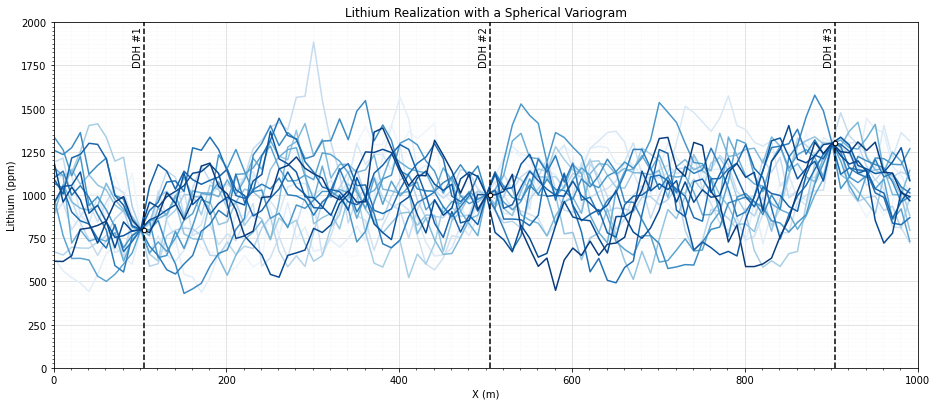

In [4]:
nreal = 20

df.loc[0,'X'] = 105; df.loc[0,'Y'] = 5.0; df.loc[0,'Lithium'] = 800
df.loc[1,'X'] = 505; df.loc[1,'Y'] = 5.0; df.loc[1,'Lithium'] = 1000
df.loc[2,'X'] = 905; df.loc[2,'Y'] = 5.0; df.loc[2,'Lithium'] = 1300

vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=90.0,hmaj1=100,hmin1=5)

plt.subplot(111)
for i in range(0, nreal):
    with io.capture_output() as captured:
        sim_spherical = geostats.sgsim(df,'X','Y','Lithium',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=2000.0,ltail=1,ltpar=0.0,utail=1,utpar=2000,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73074+i,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=0,colocorr=0.0,sec_map=0,vario=vario)
    
    plt.plot(np.arange(1,(nx*xsiz),xsiz),sim_spherical[0],color=plt.cm.Blues(i/nreal),label='Real ' + str(i+1),zorder=1)
        
plt.annotate(r'DDH #1',(92,1750),rotation = 90); plt.annotate(r'DDH #2',(492,1750),rotation = 90) 
plt.annotate(r'DDH #3',(892,1750),rotation = 90) 

plt.scatter(505,1000,s=20,color='white',edgecolor='black',zorder=10); plt.scatter(105,800,s=20,color='white',edgecolor='black',zorder=10)
plt.scatter(905,1300,s=20,color='white',edgecolor='black',zorder=10)

plt.plot([105,105],[0,2000],color='black',ls='--'); plt.plot([905,905],[0,2000],color='black',ls='--')
plt.plot([505,505],[0,2000],color='black',ls='--')
    
plt.ylim([0,2000]); plt.xlim([0,1000]) 
gca = plt.gca()
gca.xaxis.set_minor_locator(AutoMinorLocator(10))
gca.yaxis.set_minor_locator(AutoMinorLocator(10))
gca.grid(which='major', color='#DDDDDD', linewidth=0.8); gca.grid(which='minor',color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.xlabel('X (m)'); plt.ylabel('Lithium (ppm)'); plt.title('Lithium Realization with a Spherical Variogram')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2); plt.show()

#### Exponential Variogram

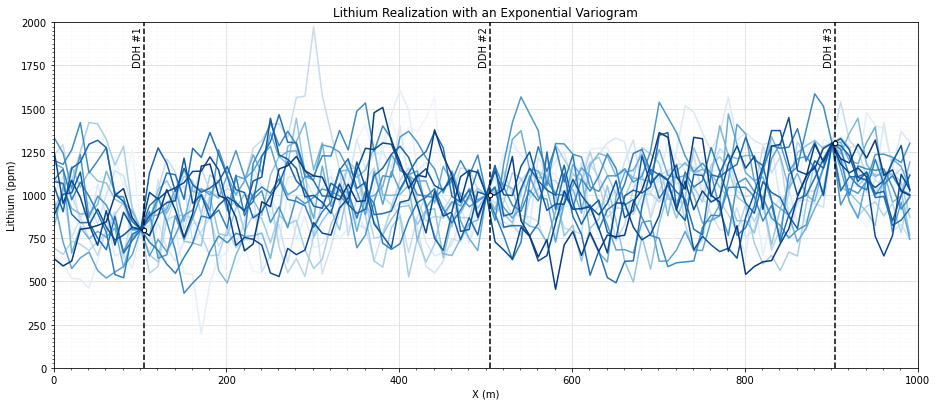

In [5]:
nreal = 20

df.loc[0,'X'] = 105; df.loc[0,'Y'] = 5.0; df.loc[0,'Lithium'] = 800
df.loc[1,'X'] = 505; df.loc[1,'Y'] = 5.0; df.loc[1,'Lithium'] = 1000
df.loc[2,'X'] = 905; df.loc[2,'Y'] = 5.0; df.loc[2,'Lithium'] = 1300

vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=2,cc1=1.0,azi1=90.0,hmaj1=100,hmin1=5)

plt.subplot(111)
for i in range(0, nreal):
    with io.capture_output() as captured:
        sim_exponential = geostats.sgsim(df,'X','Y','Lithium',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=2000.0,ltail=1,ltpar=0.0,utail=1,utpar=2000,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73074+i,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=0,colocorr=0.0,sec_map=0,vario=vario);

    plt.plot(np.arange(1,(nx*xsiz),xsiz),sim_exponential[0],color=plt.cm.Blues(i/nreal),label='Real ' + str(i+1),zorder=1)
        
plt.annotate(r'DDH #1',(92,1750),rotation = 90); plt.annotate(r'DDH #2',(492,1750),rotation = 90) 
plt.annotate(r'DDH #3',(892,1750),rotation = 90) 

plt.scatter(505,1000,s=20,color='white',edgecolor='black',zorder=10); plt.scatter(105,800,s=20,color='white',edgecolor='black',zorder=10)
plt.scatter(905,1300,s=20,color='white',edgecolor='black',zorder=10)

plt.plot([105,105],[0,2000],color='black',ls='--'); plt.plot([905,905],[0,2000],color='black',ls='--')
plt.plot([505,505],[0,2000],color='black',ls='--')
    
plt.ylim([0,2000]); plt.xlim([0,1000]) 
gca = plt.gca()
gca.xaxis.set_minor_locator(AutoMinorLocator(10))
gca.yaxis.set_minor_locator(AutoMinorLocator(10))
gca.grid(which='major', color='#DDDDDD', linewidth=0.8); gca.grid(which='minor',color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.xlabel('X (m)'); plt.ylabel('Lithium (ppm)'); plt.title('Lithium Realization with an Exponential Variogram')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2); plt.show()

#### Gaussian Variogram

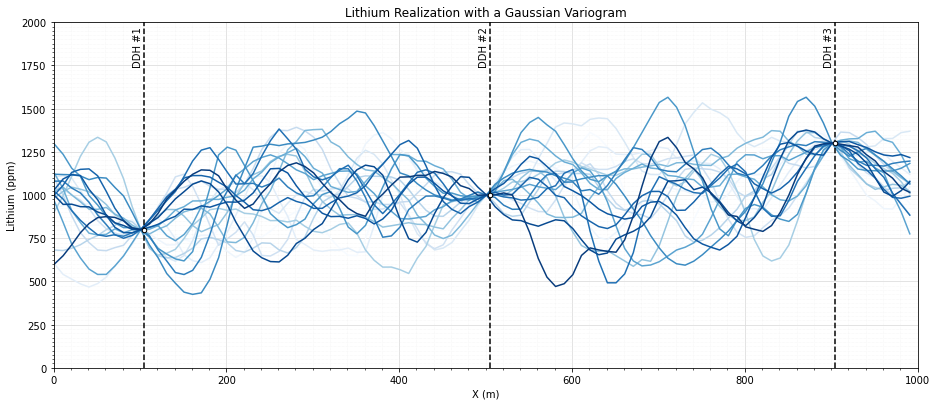

In [6]:
nreal = 20

df.loc[0,'X'] = 105; df.loc[0,'Y'] = 5.0; df.loc[0,'Lithium'] = 800
df.loc[1,'X'] = 505; df.loc[1,'Y'] = 5.0; df.loc[1,'Lithium'] = 1000
df.loc[2,'X'] = 905; df.loc[2,'Y'] = 5.0; df.loc[2,'Lithium'] = 1300

vario = GSLIB.make_variogram(nug=0.001,nst=1,it1=3,cc1=0.999,azi1=90.0,hmaj1=100,hmin1=5)

plt.subplot(111)
for i in range(0, nreal):
    with io.capture_output() as captured:
        sim_gaussian = geostats.sgsim(df,'X','Y','Lithium',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=2000.0,ltail=1,ltpar=0.0,utail=1,utpar=2000,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73074+i,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=0,colocorr=0.0,sec_map=0,vario=vario);

    plt.plot(np.arange(1,(nx*xsiz),xsiz),sim_gaussian[0],color=plt.cm.Blues(i/nreal),label='Real ' + str(i+1),zorder=1)
    
plt.annotate(r'DDH #1',(92,1750),rotation = 90); plt.annotate(r'DDH #2',(492,1750),rotation = 90) 
plt.annotate(r'DDH #3',(892,1750),rotation = 90) 

plt.scatter(505,1000,s=20,color='white',edgecolor='black',zorder=10); plt.scatter(105,800,s=20,color='white',edgecolor='black',zorder=10)
plt.scatter(905,1300,s=20,color='white',edgecolor='black',zorder=10)

plt.plot([105,105],[0,2000],color='black',ls='--'); plt.plot([905,905],[0,2000],color='black',ls='--')
plt.plot([505,505],[0,2000],color='black',ls='--')
    
plt.ylim([0,2000]); plt.xlim([0,1000]) 
gca = plt.gca()
gca.xaxis.set_minor_locator(AutoMinorLocator(10))
gca.yaxis.set_minor_locator(AutoMinorLocator(10))
gca.grid(which='major', color='#DDDDDD', linewidth=0.8); gca.grid(which='minor',color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.xlabel('X (m)'); plt.ylabel('Lithium (ppm)'); plt.title('Lithium Realization with a Gaussian Variogram')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2); plt.show()

#### Vary the Variogram Type

All variogram models plotted together.

* spherical
* exponential
* Gaussian

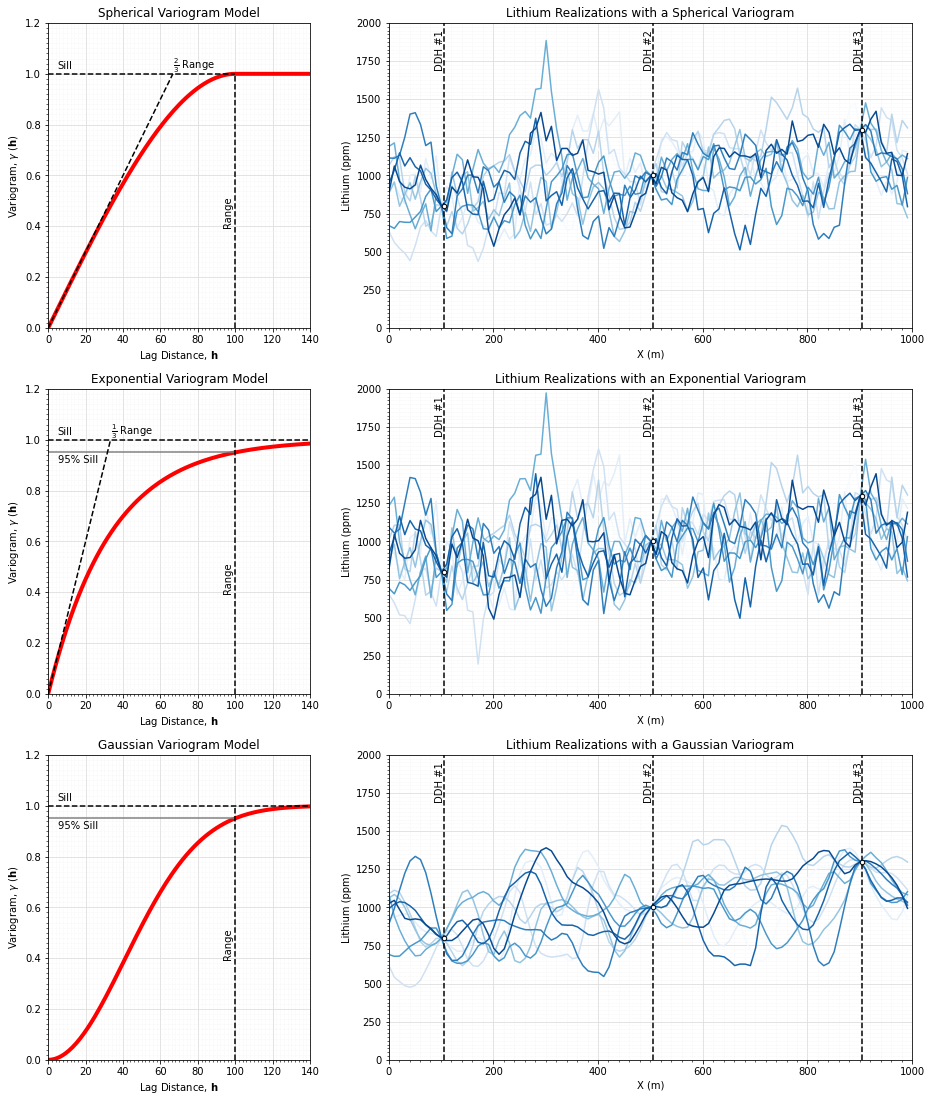

In [7]:
from matplotlib import gridspec

nreal = 10; hrange = 100; h = np.linspace(0,150,151)

fig = plt.figure()
grid_spec = gridspec.GridSpec(ncols = 2,nrows=3,width_ratios=[1, 2])

ax0 = fig.add_subplot(grid_spec[0])
gamma_sph = 1.0*(1.5*h/hrange) - 0.5*np.power(h/hrange,3)
gamma_sph[h > hrange] = 1.0
#gamma_sph = np.where(h>vrange,1.0,gamma_sph)

plot = ax0.plot(h,gamma_sph,color='red',lw=4)
plt.plot([0,100],[1.0,1.0],color='black',ls='--'); plt.annotate('Sill',[5,1.02])
plt.plot([0,hrange*2/3],[0,1.0],color='black',ls='--'); plt.annotate(r'$\frac{2}{3}$ Range',[hrange*2/3,1.02])
plt.plot([hrange,hrange],[0.0,1.0],color='black',ls='--'); plt.annotate('Range',[hrange-6.5,0.4],rotation=90.0)
gca = plt.gca()
plt.xlim([0,140]); plt.ylim([0,1.2])
plt.xlabel(r'Lag Distance, $\bf{h}$'); plt.ylabel(r'Variogram, $\gamma$ ($\bf{h}$)')

gca.xaxis.set_minor_locator(AutoMinorLocator(10))
gca.yaxis.set_minor_locator(AutoMinorLocator(10))

gca.grid(which='major', color='#DDDDDD', linewidth=0.8); gca.grid(which='minor',color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.title('Spherical Variogram Model')

ax1 = fig.add_subplot(grid_spec[1])
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=90.0,hmaj1=hrange,hmin1=5)
for i in range(0, nreal):
    with io.capture_output() as captured:
        sim_spherical = geostats.sgsim(df,'X','Y','Lithium',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=2000.0,ltail=1,ltpar=0.0,utail=1,utpar=2000,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73074+i,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=0,colocorr=0.0,sec_map=0,vario=vario);

    ax1.plot(np.arange(1,(nx*xsiz),xsiz),sim_spherical[0],color=plt.cm.Blues(i/nreal),label='Real ' + str(i+1),zorder=1)    
    
plt.annotate(r'DDH #1',(88,1700),rotation = 90); plt.annotate(r'DDH #2',(488,1700),rotation = 90) 
plt.annotate(r'DDH #3',(888,1700),rotation = 90) 

plt.scatter(505,1000,s=20,color='white',edgecolor='black',zorder=10); plt.scatter(105,800,s=20,color='white',edgecolor='black',zorder=10)
plt.scatter(905,1300,s=20,color='white',edgecolor='black',zorder=10)

plt.plot([105,105],[0,2000],color='black',ls='--'); plt.plot([905,905],[0,2000],color='black',ls='--')
plt.plot([505,505],[0,2000],color='black',ls='--')

plt.ylim([0,2000]); plt.xlim([0,1000]) 
gca = plt.gca()
gca.xaxis.set_minor_locator(AutoMinorLocator(10))
gca.yaxis.set_minor_locator(AutoMinorLocator(10))
gca.grid(which='major', color='#DDDDDD', linewidth=0.8); gca.grid(which='minor',color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.xlabel('X (m)'); plt.ylabel('Lithium (ppm)'); plt.title('Lithium Realizations with a Spherical Variogram')

ax2 = fig.add_subplot(grid_spec[2])
gamma_exp = 1.0*(1.0-np.exp(-3*(h/hrange)))

plot = ax2.plot(h,gamma_exp,color='red',lw=4)
plt.plot([0,150],[1.0,1.0],color='black',ls='--'); plt.annotate('Sill',[5,1.02])
plt.plot([0,hrange],[0.95,0.95],color='grey',ls='-'); plt.annotate('95% Sill',[5,0.91])
plt.plot([hrange,hrange],[0.0,1.0],color='black',ls='--'); plt.annotate('Range',[hrange-6.5,0.4],rotation=90.0)
plt.plot([0,hrange*1/3],[0,1.0],color='black',ls='--'); plt.annotate(r'$\frac{1}{3}$ Range',[hrange*1/3,1.02])
gca = plt.gca()
plt.xlim([0,140]); plt.ylim([0,1.2])
plt.xlabel(r'Lag Distance, $\bf{h}$'); plt.ylabel(r'Variogram, $\gamma$ ($\bf{h}$)')

gca.xaxis.set_minor_locator(AutoMinorLocator(10))
gca.yaxis.set_minor_locator(AutoMinorLocator(10))

gca.grid(which='major', color='#DDDDDD', linewidth=0.8); gca.grid(which='minor',color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.title('Exponential Variogram Model')

ax3 = fig.add_subplot(grid_spec[3])
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=2,cc1=1.0,azi1=90.0,hmaj1=hrange,hmin1=5)
for i in range(0, nreal):
    with io.capture_output() as captured:
        sim_exponential = geostats.sgsim(df,'X','Y','Lithium',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=2000.0,ltail=1,ltpar=0.0,utail=1,utpar=2000,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73074+i,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=0,colocorr=0.0,sec_map=0,vario=vario);

    ax3.plot(np.arange(1,(nx*xsiz),xsiz),sim_exponential[0],color=plt.cm.Blues(i/nreal),label='Real ' + str(i+1),zorder=1)
        
plt.annotate(r'DDH #1',(88,1700),rotation = 90); plt.annotate(r'DDH #2',(488,1700),rotation = 90) 
plt.annotate(r'DDH #3',(888,1700),rotation = 90) 

plt.scatter(505,1000,s=20,color='white',edgecolor='black',zorder=10); plt.scatter(105,800,s=20,color='white',edgecolor='black',zorder=10)
plt.scatter(905,1300,s=20,color='white',edgecolor='black',zorder=10)

plt.plot([105,105],[0,2000],color='black',ls='--'); plt.plot([905,905],[0,2000],color='black',ls='--')
plt.plot([505,505],[0,2000],color='black',ls='--')
    
plt.ylim([0,2000]); plt.xlim([0,1000]) 
gca = plt.gca()
gca.xaxis.set_minor_locator(AutoMinorLocator(10))
gca.yaxis.set_minor_locator(AutoMinorLocator(10))
gca.grid(which='major', color='#DDDDDD', linewidth=0.8); gca.grid(which='minor',color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.xlabel('X (m)'); plt.ylabel('Lithium (ppm)'); plt.title('Lithium Realizations with an Exponential Variogram')


ax4 = fig.add_subplot(grid_spec[4])
gamma_gaus = 1.0*(1.0-np.exp(-3*np.power(h/hrange,2)))

plot = ax4.plot(h,gamma_gaus,color='red',lw=4)
plt.plot([0,150],[1.0,1.0],color='black',ls='--'); plt.annotate('Sill',[5,1.02])
plt.plot([0,hrange],[0.95,0.95],color='grey',ls='-'); plt.annotate('95% Sill',[5,0.91])
plt.plot([hrange,hrange],[0.0,1.0],color='black',ls='--'); plt.annotate('Range',[hrange-6.5,0.4],rotation=90.0)
gca = plt.gca()
plt.xlim([0,140]); plt.ylim([0,1.2])
plt.xlabel(r'Lag Distance, $\bf{h}$'); plt.ylabel(r'Variogram, $\gamma$ ($\bf{h}$)')

gca.xaxis.set_minor_locator(AutoMinorLocator(10))
gca.yaxis.set_minor_locator(AutoMinorLocator(10))

gca.grid(which='major', color='#DDDDDD', linewidth=0.8); gca.grid(which='minor',color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.title('Gaussian Variogram Model')


ax5 = fig.add_subplot(grid_spec[5])
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=3,cc1=1.0,azi1=90.0,hmaj1=hrange,hmin1=5)
for i in range(0, nreal):
    with io.capture_output() as captured:
        sim_gaussian = geostats.sgsim(df,'X','Y','Lithium',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=2000.0,ltail=1,ltpar=0.0,utail=1,utpar=2000,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73074+i,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=0,colocorr=0.0,sec_map=0,vario=vario);

    ax5.plot(np.arange(1,(nx*xsiz),xsiz),sim_gaussian[0],color=plt.cm.Blues(i/nreal),label='Real ' + str(i+1),zorder=1)
        
plt.annotate(r'DDH #1',(88,1700),rotation = 90); plt.annotate(r'DDH #2',(488,1700),rotation = 90) 
plt.annotate(r'DDH #3',(888,1700),rotation = 90) 

plt.scatter(505,1000,s=20,color='white',edgecolor='black',zorder=10); plt.scatter(105,800,s=20,color='white',edgecolor='black',zorder=10)
plt.scatter(905,1300,s=20,color='white',edgecolor='black',zorder=10)

plt.plot([105,105],[0,2000],color='black',ls='--'); plt.plot([905,905],[0,2000],color='black',ls='--')
plt.plot([505,505],[0,2000],color='black',ls='--')
    
plt.ylim([0,2000]); plt.xlim([0,1000]) 
gca = plt.gca()
gca.xaxis.set_minor_locator(AutoMinorLocator(10))
gca.yaxis.set_minor_locator(AutoMinorLocator(10))
gca.grid(which='major', color='#DDDDDD', linewidth=0.8); gca.grid(which='minor',color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.xlabel('X (m)'); plt.ylabel('Lithium (ppm)'); plt.title('Lithium Realizations with a Gaussian Variogram')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=3.6, wspace=0.2, hspace=0.2); plt.show()

#### Vary the Nugget Effect

* 0% relative nugget effect
* 50% relative nugget effect
* 90% relative nugget effect

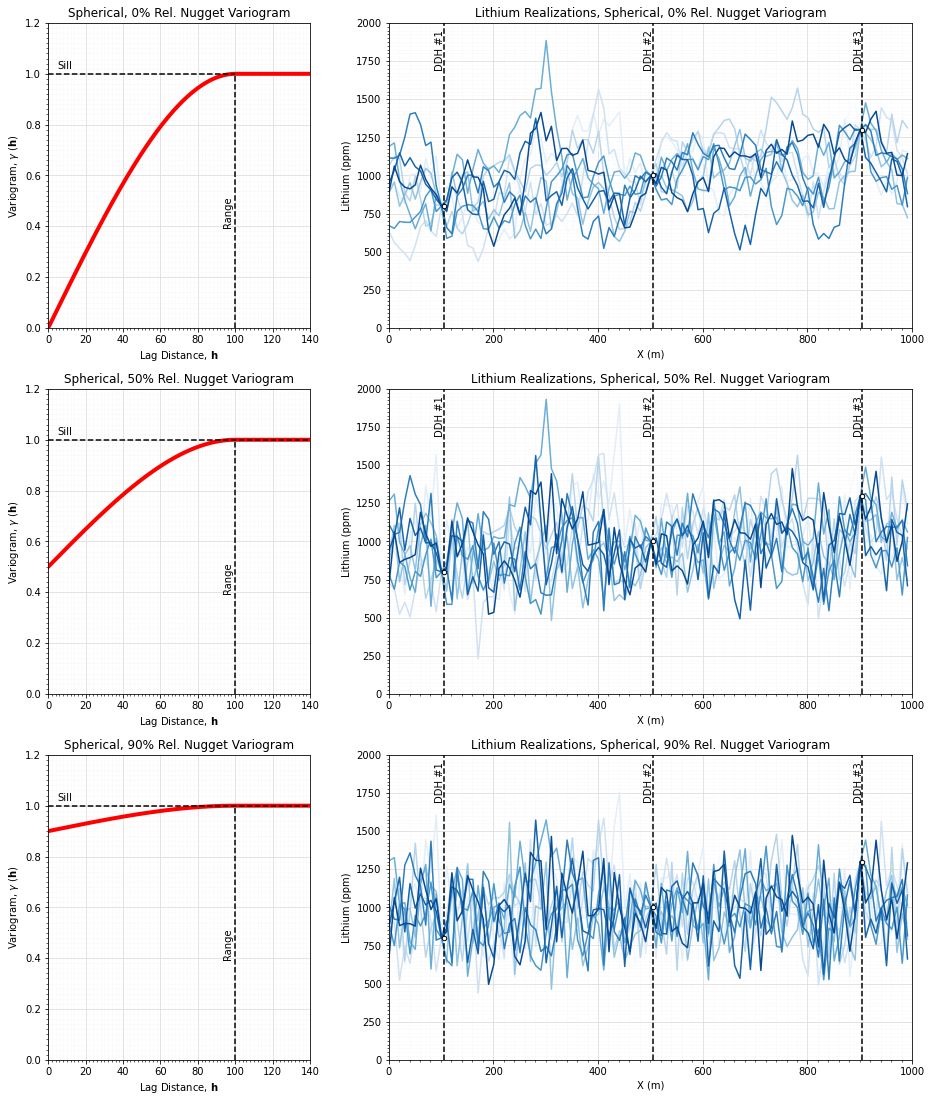

In [16]:
from matplotlib import gridspec

nreal = 10; hrange = 100; h = np.linspace(0,150,151)

fig = plt.figure()
grid_spec = gridspec.GridSpec(ncols = 2,nrows=3,width_ratios=[1, 2])

ax0 = fig.add_subplot(grid_spec[0])
nugget = 0.0
gamma = (1.0-nugget)*((1.5*h/hrange) - 0.5*np.power(h/hrange,3))+nugget
gamma[h > hrange] = 1.0
#gamma_sph = np.where(h>vrange,1.0,gamma_sph)

plot = ax0.plot(h,gamma,color='red',lw=4)
plt.plot([0,100],[1.0,1.0],color='black',ls='--'); plt.annotate('Sill',[5,1.02])

plt.plot([hrange,hrange],[0.0,1.0],color='black',ls='--'); plt.annotate('Range',[hrange-6.5,0.4],rotation=90.0)
gca = plt.gca()
plt.xlim([0,140]); plt.ylim([0,1.2])
plt.xlabel(r'Lag Distance, $\bf{h}$'); plt.ylabel(r'Variogram, $\gamma$ ($\bf{h}$)')

gca.xaxis.set_minor_locator(AutoMinorLocator(10))
gca.yaxis.set_minor_locator(AutoMinorLocator(10))

gca.grid(which='major', color='#DDDDDD', linewidth=0.8); gca.grid(which='minor',color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.title('Spherical, ' + str(int(nugget*100)) + '% Rel. Nugget Variogram')

ax1 = fig.add_subplot(grid_spec[1])
vario = GSLIB.make_variogram(nug=nugget,nst=1,it1=1,cc1=1.0-nugget,azi1=90.0,hmaj1=hrange,hmin1=5)
for i in range(0, nreal):
    with io.capture_output() as captured:
        sim_spherical = geostats.sgsim(df,'X','Y','Lithium',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=2000.0,ltail=1,ltpar=0.0,utail=1,utpar=2000,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73074+i,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=0,colocorr=0.0,sec_map=0,vario=vario);

    ax1.plot(np.arange(1,(nx*xsiz),xsiz),sim_spherical[0],color=plt.cm.Blues(i/nreal),label='Real ' + str(i+1),zorder=1)    
    
plt.annotate(r'DDH #1',(88,1700),rotation = 90); plt.annotate(r'DDH #2',(488,1700),rotation = 90) 
plt.annotate(r'DDH #3',(888,1700),rotation = 90) 

plt.scatter(505,1000,s=20,color='white',edgecolor='black',zorder=10); plt.scatter(105,800,s=20,color='white',edgecolor='black',zorder=10)
plt.scatter(905,1300,s=20,color='white',edgecolor='black',zorder=10)

plt.plot([105,105],[0,2000],color='black',ls='--'); plt.plot([905,905],[0,2000],color='black',ls='--')
plt.plot([505,505],[0,2000],color='black',ls='--')

plt.ylim([0,2000]); plt.xlim([0,1000]) 
gca = plt.gca()
gca.xaxis.set_minor_locator(AutoMinorLocator(10))
gca.yaxis.set_minor_locator(AutoMinorLocator(10))
gca.grid(which='major', color='#DDDDDD', linewidth=0.8); gca.grid(which='minor',color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.xlabel('X (m)'); plt.ylabel('Lithium (ppm)'); plt.title('Lithium Realizations, Spherical, ' + str(int(nugget*100)) + '% Rel. Nugget Variogram')

ax2 = fig.add_subplot(grid_spec[2])
nugget = 0.5
gamma = (1.0-nugget)*((1.5*h/hrange) - 0.5*np.power(h/hrange,3))+nugget
gamma[h > hrange] = 1.0

plot = ax2.plot(h,gamma,color='red',lw=4)
plt.plot([0,150],[1.0,1.0],color='black',ls='--'); plt.annotate('Sill',[5,1.02])
plt.plot([hrange,hrange],[0.0,1.0],color='black',ls='--'); plt.annotate('Range',[hrange-6.5,0.4],rotation=90.0)
gca = plt.gca()
plt.xlim([0,140]); plt.ylim([0,1.2])
plt.xlabel(r'Lag Distance, $\bf{h}$'); plt.ylabel(r'Variogram, $\gamma$ ($\bf{h}$)')

gca.xaxis.set_minor_locator(AutoMinorLocator(10))
gca.yaxis.set_minor_locator(AutoMinorLocator(10))

gca.grid(which='major', color='#DDDDDD', linewidth=0.8); gca.grid(which='minor',color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.title('Spherical, ' + str(int(nugget*100)) + '% Rel. Nugget Variogram')

ax3 = fig.add_subplot(grid_spec[3])
vario = GSLIB.make_variogram(nug=nugget,nst=1,it1=1,cc1=1.0-nugget,azi1=90.0,hmaj1=hrange,hmin1=5)
for i in range(0, nreal):
    with io.capture_output() as captured:
        sim_exponential = geostats.sgsim(df,'X','Y','Lithium',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=2000.0,ltail=1,ltpar=0.0,utail=1,utpar=2000,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73074+i,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=0,colocorr=0.0,sec_map=0,vario=vario);

    ax3.plot(np.arange(1,(nx*xsiz),xsiz),sim_exponential[0],color=plt.cm.Blues(i/nreal),label='Real ' + str(i+1),zorder=1)
        
plt.annotate(r'DDH #1',(88,1700),rotation = 90); plt.annotate(r'DDH #2',(488,1700),rotation = 90) 
plt.annotate(r'DDH #3',(888,1700),rotation = 90) 

plt.scatter(505,1000,s=20,color='white',edgecolor='black',zorder=10); plt.scatter(105,800,s=20,color='white',edgecolor='black',zorder=10)
plt.scatter(905,1300,s=20,color='white',edgecolor='black',zorder=10)

plt.plot([105,105],[0,2000],color='black',ls='--'); plt.plot([905,905],[0,2000],color='black',ls='--')
plt.plot([505,505],[0,2000],color='black',ls='--')
    
plt.ylim([0,2000]); plt.xlim([0,1000]) 
gca = plt.gca()
gca.xaxis.set_minor_locator(AutoMinorLocator(10))
gca.yaxis.set_minor_locator(AutoMinorLocator(10))
gca.grid(which='major', color='#DDDDDD', linewidth=0.8); gca.grid(which='minor',color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.xlabel('X (m)'); plt.ylabel('Lithium (ppm)'); plt.title('Lithium Realizations, Spherical, ' + str(int(nugget*100)) + '% Rel. Nugget Variogram')


ax4 = fig.add_subplot(grid_spec[4])
nugget = 0.9
gamma = (1.0-nugget)*((1.5*h/hrange) - 0.5*np.power(h/hrange,3))+nugget
gamma[h > hrange] = 1.0

plot = ax4.plot(h,gamma,color='red',lw=4)
plt.plot([0,150],[1.0,1.0],color='black',ls='--'); plt.annotate('Sill',[5,1.02])
plt.plot([hrange,hrange],[0.0,1.0],color='black',ls='--'); plt.annotate('Range',[hrange-6.5,0.4],rotation=90.0)
gca = plt.gca()
plt.xlim([0,140]); plt.ylim([0,1.2])
plt.xlabel(r'Lag Distance, $\bf{h}$'); plt.ylabel(r'Variogram, $\gamma$ ($\bf{h}$)')

gca.xaxis.set_minor_locator(AutoMinorLocator(10))
gca.yaxis.set_minor_locator(AutoMinorLocator(10))

gca.grid(which='major', color='#DDDDDD', linewidth=0.8); gca.grid(which='minor',color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.title('Spherical, ' + str(int(nugget*100)) + '% Rel. Nugget Variogram')

ax5 = fig.add_subplot(grid_spec[5])
vario = GSLIB.make_variogram(nug=nugget,nst=1,it1=1,cc1=1.0-nugget,azi1=90.0,hmaj1=hrange,hmin1=5)
for i in range(0, nreal):
    with io.capture_output() as captured:
        sim_gaussian = geostats.sgsim(df,'X','Y','Lithium',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=2000.0,ltail=1,ltpar=0.0,utail=1,utpar=2000,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73074+i,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=0,colocorr=0.0,sec_map=0,vario=vario);

    ax5.plot(np.arange(1,(nx*xsiz),xsiz),sim_gaussian[0],color=plt.cm.Blues(i/nreal),label='Real ' + str(i+1),zorder=1)
        
plt.annotate(r'DDH #1',(88,1700),rotation = 90); plt.annotate(r'DDH #2',(488,1700),rotation = 90) 
plt.annotate(r'DDH #3',(888,1700),rotation = 90) 

plt.scatter(505,1000,s=20,color='white',edgecolor='black',zorder=10); plt.scatter(105,800,s=20,color='white',edgecolor='black',zorder=10)
plt.scatter(905,1300,s=20,color='white',edgecolor='black',zorder=10)

plt.plot([105,105],[0,2000],color='black',ls='--'); plt.plot([905,905],[0,2000],color='black',ls='--')
plt.plot([505,505],[0,2000],color='black',ls='--')
    
plt.ylim([0,2000]); plt.xlim([0,1000]) 
gca = plt.gca()
gca.xaxis.set_minor_locator(AutoMinorLocator(10))
gca.yaxis.set_minor_locator(AutoMinorLocator(10))
gca.grid(which='major', color='#DDDDDD', linewidth=0.8); gca.grid(which='minor',color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.xlabel('X (m)'); plt.ylabel('Lithium (ppm)'); plt.title('Lithium Realizations, Spherical, ' + str(int(nugget*100)) + '% Rel. Nugget Variogram')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=3.6, wspace=0.2, hspace=0.2); plt.show()

#### Comments

This was a basic demonstration of the impact of variogram model choice on spatial realizations of lithium grade. Much more could be done, I have other demonstrations on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations and many other workflows available at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy. 
  
I hope this was helpful,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)